# High-resolution deterministic forecasts

This notebook demonstrates using [netcdf4-python](http://netcdf4-python.googlecode.com) to read some [NOMADS](http://nomads.ncep.noaa.gov/txt_descriptions/NOMADS_doc.shtml) [openDAP](http://opendap.org) GFS forecast data, use [numpy](http://numpy.org) to do some rudimentary analysis, and have [matplotlib](http://matplotlib.org) and [Basemap](http://matplotlib.org/basemap) plot the results. 

We start by loading the required modules. First up is the Matplotlib Basemap package and related matplotlib modules (pyplot, gridspec, cm and axes_grid1), then Numpy, netCDF4-python, some datetime routines and IPython widgets to make this notebook interactive.


In [1]:
%matplotlib inline
from mpl_toolkits.basemap import Basemap  # import Basemap matplotlib toolkit
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from mpl_toolkits.basemap import cm as basemapcm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np

from netCDF4 import Dataset, num2date # netcdf4-python module
from datetime import datetime, timedelta

# Import widgets for interactive notebook
from IPython.html.widgets import interact, fixed
from IPython.html import widgets

:0: FutureWarning: IPython widgets are experimental and may change in the future.


A small function to set the appropriate forecast time. There's usually about a 4-5 hour delay between the initial time and the data becoming available on the NOMADS system. This only picks up the 00Z or 12Z runs - a bit more logic would enable the function to return the 06Z or 18Z time stamps as well.

In [2]:
def get_forecast_time(delay=6):
    now = datetime.utcnow()
    print "Current time: {0}".format(now)
    fcast_time = datetime.utcnow()
    if now.hour < delay:
        fcast_time = fcast_time - timedelta(1)
        fcast_time = fcast_time.replace(hour=delay+6, minute=0)
    elif (now.hour >=delay and now.hour < (delay+12)):
        fcast_time = fcast_time.replace(hour=0)
    elif now.hour >= (delay+12):
        fcast_time = fcast_time.replace(hour=12)
    print "Forecast time: {0}".format(fcast_time)
    return fcast_time


Now we construct the URL for the latest available dataset:

In [3]:
fcast_time = get_forecast_time()

fcast_date_string = fcast_time.strftime("gfs%Y%m%d/gfs_0p25_%Hz")
data_url = 'http://nomads.ncep.noaa.gov:80/dods/gfs_0p25/{0}'.format(fcast_date_string)
print "Dataset URL: " +  data_url

gfs_fcst = Dataset(data_url, mode='r')
print ""
print "Dataset description:"
print gfs_fcst # get some summary information about the dataset

Current time: 2015-04-14 02:49:52.160000
Forecast time: 2015-04-13 12:00:52.160000
Dataset URL: http://nomads.ncep.noaa.gov:80/dods/gfs_0p25/gfs20150413/gfs_0p25_12z

Dataset description:
<type 'netCDF4.Dataset'>
root group (NETCDF3_CLASSIC file format):
    title: GFS 0.25 deg starting from 12Z13apr2015, downloaded Apr 13 16:44 UTC
    Conventions: COARDS
GrADS
    dataType: Grid
    history: Mon Apr 13 16:54:01 GMT 2015 : imported by GrADS Data Server 2.0
    dimensions: lat, lev, lon, time
    variables: time, lev, lat, lon, absvprs, no4lftxsfc, no5wavh500mb, acpcpsfc, albdosfc, apcpsfc, capesfc, cape180_0mb, cape255_0mb, cfrzrsfc, cicepsfc, cinsfc, cin180_0mb, cin255_0mb, clwmrprs, cpofpsfc, cpratsfc, crainsfc, csnowsfc, cwatclm, cworkclm, dlwrfsfc, dpt2m, dswrfsfc, fldcpsfc, gfluxsfc, gustsfc, hgtsfc, hgtprs, hgt2pv, hgtneg2pv, hgttop0c, hgt0c, hgtmwl, hgttrop, hindexsfc, hlcy3000_0m, hpblsfc, icahtmwl, icahttrop, icecsfc, landsfc, lftxsfc, lhtflsfc, msletmsl, o3mrprs, pevprsfc, p

In [7]:
time = gfs_fcst.variables['time']
print time
valid_dates = num2date(time[:], time.units).tolist()

timelist = [d.strftime('%Y-%m-%d %H:%M') for d in valid_dates]
print "Valid times:"
print timelist
levels = gfs_fcst.variables['lev']
print "Levels:"
print [level for level in levels[:]]

<type 'netCDF4.Variable'>
float64 time(time)
    grads_dim: t
    grads_mapping: linear
    grads_size: 81
    grads_min: 12z13apr2015
    grads_step: 3hr
    units: days since 1-1-1 00:00:0.0
    long_name: time
    minimum: 12z13apr2015
    maximum: 12z23apr2015
    resolution: 0.125
unlimited dimensions: 
current shape = (81,)

Valid times:
['2015-04-13 12:00', '2015-04-13 15:00', '2015-04-13 18:00', '2015-04-13 21:00', '2015-04-14 00:00', '2015-04-14 03:00', '2015-04-14 06:00', '2015-04-14 09:00', '2015-04-14 12:00', '2015-04-14 15:00', '2015-04-14 18:00', '2015-04-14 21:00', '2015-04-15 00:00', '2015-04-15 03:00', '2015-04-15 06:00', '2015-04-15 09:00', '2015-04-15 12:00', '2015-04-15 15:00', '2015-04-15 18:00', '2015-04-15 21:00', '2015-04-16 00:00', '2015-04-16 03:00', '2015-04-16 06:00', '2015-04-16 09:00', '2015-04-16 12:00', '2015-04-16 15:00', '2015-04-16 18:00', '2015-04-16 21:00', '2015-04-17 00:00', '2015-04-17 03:00', '2015-04-17 06:00', '2015-04-17 09:00', '2015-04-17 1

In [8]:
def plot_rain(timestamp):
    idx = timelist.index(timestamp)
    apcp = gfs_fcst.variables['apcpsfc'][idx,:,:]
    prmsl = gfs_fcst.variables['prmslmsl'][idx,:,:]
    hgt1000 = gfs_fcst.variables['hgtprs'][idx,0,:,:]
    hgt500 = gfs_fcst.variables['hgtprs'][idx,12,:,:]
    thk = (hgt500 - hgt1000)/10.

    lats = gfs_fcst.variables['lat'][:]; lons = gfs_fcst.variables['lon'][:]
    lons, lats = np.meshgrid(lons, lats)
    fig = plt.figure(figsize=(18,10))

    m = Basemap(projection='mill', llcrnrlon=80., llcrnrlat=-45, 
                urcrnrlon=180., urcrnrlat=0.,resolution='i')
    
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    x,y = m(lons, lats) # convert lats/lons to map projection coordinates
    clevs = [0,.1,.25,.5,.75,1.0,1.5,2.0,3.0,4.0,5.0,7.0,10.0,
             15.0,20.0,25.0,30.0,40.0,50.0,60.0,75.0]

    cs = m.contourf(x,y, apcp, clevs, cmap=basemapcm.s3pcpn, extend='max')  # color-filled contours
    ct = m.contour(x, y, thk, np.arange(500, 600, 4), colors='0.75', linestyle='--')
    cp = m.contour(x, y, prmsl/100., np.arange(900, 1040, 2), colors='k')
    cb = m.colorbar(cs, extend='max')  # draw colorbar
    parallels = m.drawparallels(np.arange(-50, 0, 10), labels=[1,0,0,0])  # draw parallels, label on left
    meridians = m.drawmeridians(np.arange(80, 190, 10), labels=[0,0,0,1]) # label meridians on bottom
    
    fig.suptitle('Forecast apcp (mm) from %s for %s' % (valid_dates[0],valid_dates[idx]),fontweight='bold')

In [9]:
def plot_wind(timestamp):
    idx = timelist.index(timestamp)
    uu = gfs_fcst.variables['ugrdsig995'][idx,:,:]
    vv = gfs_fcst.variables['vgrdsig995'][idx,:,:]
    wspd = np.sqrt(uu*uu + vv*vv)
    pmsl = gfs_fcst.variables['prmslmsl'][idx,:,:]
    hgt1000 = gfs_fcst.variables['hgtprs'][idx,0,:,:]
    hgt500 = gfs_fcst.variables['hgtprs'][idx,12,:,:]
    thk = (hgt500 - hgt1000)/10.


    lats = gfs_fcst.variables['lat'][:]; lons = gfs_fcst.variables['lon'][:]
    lons, lats = np.meshgrid(lons, lats)
    fig = plt.figure(figsize=(18,10))

    m = Basemap(projection='mill',llcrnrlon=80., llcrnrlat=-45, 
                urcrnrlon=180., urcrnrlat=0.,resolution='i')
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    x,y = m(lons, lats) # convert lats/lons to map projection coordinates
    clevs = np.arange(5.,41.)

    cs = m.contourf(x,y,wspd,clevs,cmap=basemapcm.GMT_haxby_r, extend='both')  # color-filled contours
    ct = m.contour(x,y,thk, np.arange(500, 600, 4), colors='0.75', linestyle='--')
    cp = m.contour(x,y,pmsl/100.,np.arange(900, 1040, 2), colors='k')
    cb = m.colorbar(cs,extend='both')  # draw colorbar
    parallels = m.drawparallels(np.arange(-50,0,10),labels=[1,0,0,0])  # draw parallels, label on left
    meridians = m.drawmeridians(np.arange(80,190,10),labels=[0,0,0,1]) # label meridians on bottom
    
    fig.suptitle('Forecast wind speed (m/s) from %s for %s' % (valid_dates[0],valid_dates[idx]),fontweight='bold')
    

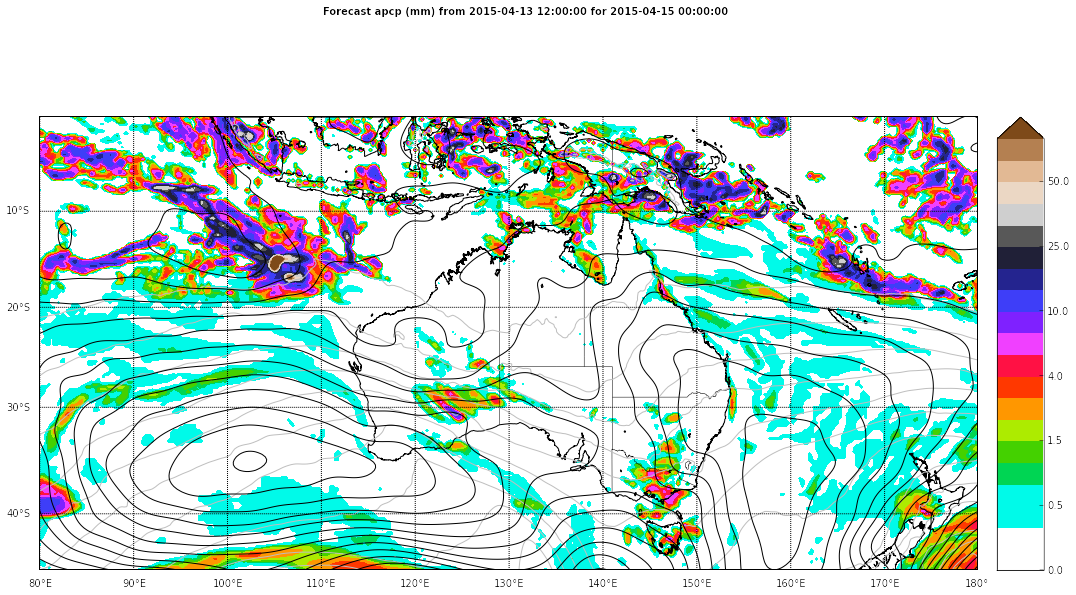

In [10]:
interact(plot_rain, timestamp=widgets.Dropdown(options=timelist, value=timelist[1]))

<function __main__.plot_wind>

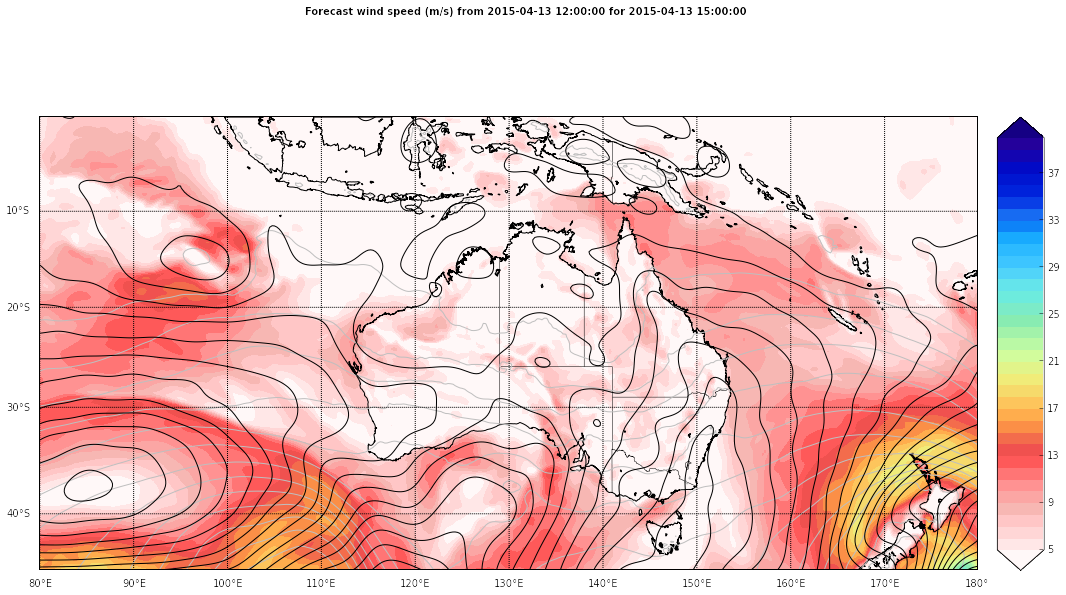

In [11]:
interact(plot_wind, timestamp=widgets.Dropdown(options=timelist, value=timelist[1]))